# General Library Info

Cells: A549
<br>
Editor: ABE8e (RDA867) / TadCBEd (RDB270)
<br>
Library: TP53 tiling NNNN PAM (CP1845/CP2087/CP2088/CP2089/CP2090)

### Importing Packages

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from poola import core as pool
from scipy import stats
import matplotlib as mpl
import gpplot as gpp
import seaborn as sns
gpp.set_aesthetics()

pd.set_option('display.max_columns', None)

### Defining functions

In [2]:
def newcol_name(unexpected_count_df, condition_df):
    #renames columns with barcodes based on condition map
    condition_df[1] = condition_df[1].replace(np.nan, 'Nothing') 
    new_cols = []
    for col in unexpected_count_df.columns:
        if col in condition_df[0].to_list():
            new_col = condition_df[condition_df[0] == col][1].to_list()
        else: 
            new_col = [col]
        new_cols.extend(new_col)   
    unexpected_count_df.columns = new_cols

def regex_seq(reference_df, guide_seq_col = 'sgRNA Target Sequence', 
              chr_change = 'A', regex_pattern = '[AG]'):
    #adds a column to the reference file with regex representing all possible combinations of A>G (or C>T if CBE) edits that may occur within a guide
    regex_list = []
    for seq in reference_df[guide_seq_col]:
        pos_a = [pos for pos, char in enumerate(seq) if char == chr_change]
        temp = list(seq)
        for pos in pos_a:
            temp[pos] = regex_pattern
        string = "".join(temp)
        regex_list.append(string)
    reference_df['regex'] = regex_list

def regex_match(reference_df, unexpected_count_df, 
                reference_regex_col = 'regex', reference_seq_col = 'sgRNA Target Sequence',
                unexpected_count_seq_col = 'Sequence'):
    #makes a dictionary mapping each guide to each of mismatched sequences seen in unexpected counts file
    long_list = []  
    my_dict = {}
    for seq in range(reference_df.shape[0]):
        r = re.compile(reference_df[reference_regex_col][seq])
        newlist = list(filter(r.match, unexpected_count_df[unexpected_count_seq_col].to_list()))
        long_list.extend(newlist)
        my_dict[reference_df[reference_seq_col][seq]] = newlist
    return long_list, my_dict

def df_align(mismatch_dict):
    #creates a dataframe with each row as a guide and mismatched seq, location of mismatch,
        #and the number of mismatches between the guide and the mismatched sequence 
    df = pd.DataFrame(columns =['guide_seq','mismatch_seq', 'loc_mismatch', 'number_mis_seq'])
    pos_mismatch = []
    for key, values in mismatch_dict.items():
        if len(values)>0:
            for val in values:
                loc_mismatch = [i for i in range(len(key)) if key[i] != val[i]]
                pos_mismatch.extend(loc_mismatch)
                row_to_append = pd.DataFrame([{'guide_seq':key, 'mismatch_seq':val,
                                               'loc_mismatch':loc_mismatch,'number_mis_seq':len(loc_mismatch)}])
                df = pd.concat([df,row_to_append])
        else:
            continue
    return df, pos_mismatch

In [3]:
def percent_mismatch(cols_to_sum, counts, unexpected_count, align_to_df):
    #this function takes the mismatch counts and total counts per guide and finds the percent mismatched reads/guide
    #align_to_df is generated in the previous functions
    counts['sg_count_total'] = counts[cols_to_sum].sum(axis=1)
    mismatch_to_norm = []
    mismatch_to_norm = pd.merge(counts, align_to_df, right_on="guide_seq", left_on='Construct Barcode',how="left")
    
    mismatch_to_norm = pd.merge(mismatch_to_norm, unexpected_count, right_on="Sequence", left_on='mismatch_seq',how="left")
    col_to_keep = ['Construct Barcode', 'mismatch_seq', 'sg_count_total', 'Total']
    mismatch_simple = mismatch_to_norm[col_to_keep]
    mismatch_simple = mismatch_simple.rename(columns={'Total': 'mismatch_total'})
    
    #aggregate by guide_seq so that we have total mismatches per guide, rather than count per mismatch
    unique_sg = mismatch_simple.drop_duplicates(subset=['Construct Barcode'])
    col_to_keep_2 = ['Construct Barcode', 'sg_count_total']
    unique_sg = unique_sg[col_to_keep_2]
    sum_by_sg = mismatch_simple.groupby('Construct Barcode')['mismatch_total'].sum().reset_index()
    sum_by_sg = pd.merge(sum_by_sg, unique_sg, on='Construct Barcode')
    sum_by_sg['sg_count_total'] = sum_by_sg['mismatch_total']+sum_by_sg['sg_count_total']
    sum_by_sg['percent'] = sum_by_sg['mismatch_total']/sum_by_sg['sg_count_total']*100
    return sum_by_sg

In [4]:
def across_guide(align_to_df, unexpected_count, sum_by_sg):
    editing_by_pos = pd.merge(unexpected_count, align_to_df, left_on='Sequence',right_on="mismatch_seq", how="right")
    col_to_keep = ['guide_seq', 'mismatch_seq', 'loc_mismatch','Total']
    editing_by_pos = editing_by_pos[col_to_keep]
    editing_by_pos = editing_by_pos.rename(columns={'Total': 'mm_total'})
    sgrna_exploded = editing_by_pos.explode('loc_mismatch').reset_index(drop=True)
    sgrna_edit = sgrna_exploded.groupby(['guide_seq','loc_mismatch']).sum(numeric_only = True).reset_index()
    sgrna_edit_pos = pd.merge(sgrna_edit, sum_by_sg, left_on='guide_seq',right_on='Construct Barcode',how="right")
    sgrna_edit_pos['editing_per_nt'] = sgrna_edit_pos['mm_total']/sgrna_edit_pos['sg_count_total']*100
    return sgrna_edit_pos

In [5]:
#The general goal here is that we want to take the reads found in unexpected counts that map back 
    #to a guide and add them to the counts data frame for each guide to be used in LFC analysis. 
    #We are hoping that mapping back additional guides can help ROC/AUC curves and replicate correlations. 
    #Here we want to use all guides/all conditions.

def mapping_adding(unexpected_count, align_to_df, counts):
    #sum same barcode columns into 1 column of each condition
    unexpected_count_grouped = unexpected_count.groupby(unexpected_count.columns, axis=1).sum()
    #merge unexpected sequences with their guide names
    unexpected_count_matched = pd.merge(unexpected_count_grouped, align_to_df, left_on='Sequence', right_on='mismatch_seq',
                                   how='right')
    #sum rows that map to the same sgRNA
    unexpected_count_final = unexpected_count_matched.groupby('guide_seq').sum().reset_index()
    
    #merge counts and unexpected counts by sgrna
    counts_merged = pd.merge(counts, unexpected_count_final, left_on='Construct Barcode', right_on='guide_seq',
                         suffixes=('_df2', '_df1'))
    exclude_columns = {'Construct Barcode','Construct IDs','Potential IDs','Sequence','Total','guide_seq','mismatch_seq','loc_mismatch','number_mis_seq'}
    columns_to_sum = set(counts.columns).intersection(set(unexpected_count_final.columns)) - exclude_columns

    for col in columns_to_sum:
        counts_merged[col] = counts_merged[f'{col}_df2'] + counts_merged[f'{col}_df1']
        counts_merged.drop([f'{col}_df2', f'{col}_df1'], axis=1, inplace=True)
    #retrieve guides that did not undergo any self editing (no match in mismatched counts)
    filtered_counts = counts[~counts['Construct Barcode'].isin(counts_merged['Construct Barcode'])].reset_index()

    #we'll now add the normal counts to the unexpected counts file
    counts_merged_final = pd.concat([counts_merged, filtered_counts], ignore_index=True).reindex(columns=counts_merged.columns)
    return counts_merged_final

# ABE presence-based selection

In [2]:
condition = pd.read_csv('../../required_data/TP53/GPP-5315_Ganna Reint_conditions.csv', header = None)
reference = pd.read_csv('../../required_data/TP53/TP53_tiling_NNNN_BE_annotations.csv')
unexpected_count = pd.read_table('../../required_data/TP53/unexpected_counts_TP53_presence.txt')
counts = pd.read_table('../../required_data/TP53/counts_TP53_presence.txt')

In [7]:
def regex_seq(reference_df, guide_seq_col = 'sgRNA Target Sequence', 
              chr_change = 'A', regex_pattern = '[AG]'):
    #adds a column to the reference file with regex representing all possible combinations of A>G (or C>T if CBE) edits that may occur within a guide
    regex_list = []
    for seq in reference_df[guide_seq_col]:
        pos_a = [pos for pos, char in enumerate(seq) if char == chr_change]
        temp = list(seq)
        for pos in pos_a:
            temp[pos] = regex_pattern
        string = "".join(temp)
        regex_list.append(string)
    reference_df['regex'] = regex_list

In [8]:
newcol_name(unexpected_count, condition)
regex_seq(reference)
seq_match, dic_seq_match = regex_match(reference, unexpected_count)
align_to_df, AG_pos_mismatch= df_align(dic_seq_match)

In [9]:
#limit scope to only TP53-targeting genes from the DO condition
cols = ['Construct Barcode','Construct IDs','A549_RDA867CP1845DropoutA21', 'A549_RDA867CP1845DropoutB21']
counts_DO = counts[cols]
counts_DO = counts_DO[counts_DO['Construct IDs']=='ENSG00000141510']
unexpected_count_DO = unexpected_count[['Sequence', 'A549_RDA867CP1845DropoutA21', 'A549_RDA867CP1845DropoutB21']]

In [10]:
#find the total number of mismatches of these conditions
cols_to_sum = ['A549_RDA867CP1845DropoutA21', 'A549_RDA867CP1845DropoutB21']
unexpected_count_DO['Total']=unexpected_count_DO[cols_to_sum].sum(axis=1)

/var/folders/nm/6_wl7tx50tq5bqfp8vzf4m6r0000gq/T/ipykernel_68353/2926323003.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unexpected_count_DO['Total']=unexpected_count_DO[cols_to_sum].sum(axis=1)


In [11]:
sum_by_sg_abe_presence  = percent_mismatch(cols_to_sum, counts_DO, unexpected_count_DO, align_to_df)

sgrna_edit_abe_pos_presence = across_guide(align_to_df, unexpected_count_DO, sum_by_sg_abe_presence)
#this includes 2734 TP53-targeting guides. 52 are excluded because they do not contain an A.

Text(0.5, 1.0, 'ABE presence-based selection editing across TP53')

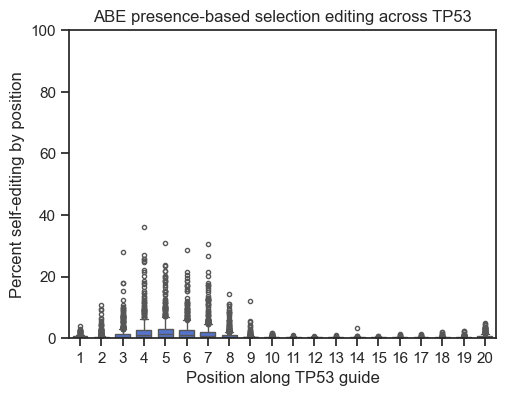

In [14]:
fig, ax = plt.subplots(figsize=(5.5, 4))
a = sns.boxplot(data=sgrna_edit_abe_pos_presence, y="editing_per_nt", x="loc_mismatch", color='royalblue',width=.7,fliersize=3)
a.set_xlabel("Position along TP53 guide")
plt.xticks(ticks=range(20), labels=range(1, 21))
a.set_ylim([0,100])
plt.yticks([0, 20, 40, 60, 80, 100])
a.set_ylabel("Percent self-editing by position")
a.set_title("ABE presence-based selection editing across TP53")

In [15]:
counts_merged_final = mapping_adding(unexpected_count, align_to_df, counts)
counts_merged_final.to_csv('../../required_data/TP53/counts_with_mismatches_ABE_presence.csv')

/var/folders/nm/6_wl7tx50tq5bqfp8vzf4m6r0000gq/T/ipykernel_68353/1401985157.py:8: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  unexpected_count_grouped = unexpected_count.groupby(unexpected_count.columns, axis=1).sum()


# ABE activity-based selection

In [3]:
condition = pd.read_csv('../../required_data/TP53/GPP-5316_Ganna Reint_conditions.csv', header = None)
reference = pd.read_csv('../../required_data/TP53/TP53_tiling_NNNN_BE_annotations.csv')
unexpected_count = pd.read_table('../../required_data/TP53/unexpected_counts_TP53_activity.txt')
counts = pd.read_table('../../required_data/TP53/counts_TP53_activity.txt')

In [17]:
def regex_seq(reference_df, guide_seq_col = 'sgRNA Target Sequence', 
              chr_change = 'A', regex_pattern = '[AG]'):
    #adds a column to the reference file with regex representing all possible combinations of A>G (or C>T if CBE) edits that may occur within a guide
    regex_list = []
    for seq in reference_df[guide_seq_col]:
        pos_a = [pos for pos, char in enumerate(seq) if char == chr_change]
        temp = list(seq)
        for pos in pos_a:
            temp[pos] = regex_pattern
        string = "".join(temp)
        regex_list.append(string)
    reference_df['regex'] = regex_list

In [18]:
newcol_name(unexpected_count, condition)
regex_seq(reference)
seq_match, dic_seq_match = regex_match(reference, unexpected_count)
align_to_df, AG_pos_mismatch= df_align(dic_seq_match)

In [19]:
#limit scope to only TP53-targeting genes from the DO condition
cols = ['Construct Barcode','Construct IDs','A549_RDA867CP2087DropoutA21', 'A549_RDA867CP2088DropoutA21']
counts_DO = counts[cols]
counts_DO = counts_DO[counts_DO['Construct IDs']=='ENSG00000141510']

unexpected_count_DO = unexpected_count[['Sequence', 'A549_RDA867CP2087DropoutA21', 'A549_RDA867CP2088DropoutA21']]

In [20]:
#find the total number of mismatches of these conditions
cols_to_sum = ['A549_RDA867CP2087DropoutA21', 'A549_RDA867CP2088DropoutA21']
unexpected_count_DO['Total']=unexpected_count_DO[cols_to_sum].sum(axis=1)

/var/folders/nm/6_wl7tx50tq5bqfp8vzf4m6r0000gq/T/ipykernel_68353/1444340162.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unexpected_count_DO['Total']=unexpected_count_DO[cols_to_sum].sum(axis=1)


In [21]:
sum_by_sg_abe_activity  = percent_mismatch(cols_to_sum, counts_DO, unexpected_count_DO, align_to_df)

sgrna_edit_abe_pos_activity = across_guide(align_to_df, unexpected_count_DO, sum_by_sg_abe_activity)

Text(0.5, 1.0, 'ABE activity-based selection editing across TP53')

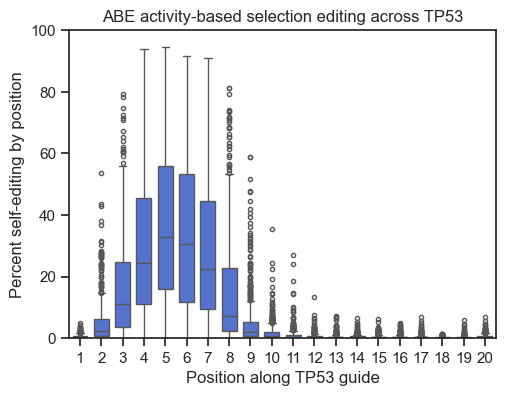

In [36]:
fig, ax = plt.subplots(figsize=(5.5, 4))
a = sns.boxplot(data=sgrna_edit_abe_pos_activity, y="editing_per_nt", x="loc_mismatch", color='royalblue',width=.7,fliersize=3)
a.set_xlabel("Position along TP53 guide")
plt.xticks(ticks=range(20), labels=range(1, 21))
a.set_ylim([0,100])
plt.yticks([0, 20, 40, 60, 80, 100])
a.set_ylabel("Percent self-editing by position")
a.set_title("ABE activity-based selection editing across TP53")

In [37]:
counts_merged_final = mapping_adding(unexpected_count, align_to_df, counts)
counts_merged_final.to_csv('../../required_data/TP53/counts_with_mismatches_ABE_activity.csv')

/var/folders/nm/6_wl7tx50tq5bqfp8vzf4m6r0000gq/T/ipykernel_68353/1401985157.py:8: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  unexpected_count_grouped = unexpected_count.groupby(unexpected_count.columns, axis=1).sum()


# CBE presence-based selection

In [4]:
condition = pd.read_csv('../../required_data/TP53/GPP-5315_Ganna Reint_conditions.csv', header = None)
reference = pd.read_csv('../../required_data/TP53/TP53_tiling_NNNN_BE_annotations.csv')
unexpected_count = pd.read_table('../../required_data/TP53/unexpected_counts_TP53_presence.txt')
counts = pd.read_table('../../required_data/TP53/counts_TP53_presence.txt')

In [39]:
def regex_seq(reference_df, guide_seq_col = 'sgRNA Target Sequence', 
              chr_change = 'C', regex_pattern = '[CT]'):
    #adds a column to the reference file with regex representing all possible combinations of A>G (or C>T if CBE) edits that may occur within a guide
    regex_list = []
    for seq in reference_df[guide_seq_col]:
        pos_a = [pos for pos, char in enumerate(seq) if char == chr_change]
        temp = list(seq)
        for pos in pos_a:
            temp[pos] = regex_pattern
        string = "".join(temp)
        regex_list.append(string)
    reference_df['regex'] = regex_list

In [40]:
newcol_name(unexpected_count, condition)
regex_seq(reference)
seq_match, dic_seq_match = regex_match(reference, unexpected_count)
align_to_df, AG_pos_mismatch= df_align(dic_seq_match)

In [41]:
#limit scope to only TP53-targeting genes from the DO condition
cols = ['Construct Barcode','Construct IDs','A549_RDB270CP1845DropoutA21', 'A549_RDB270CP1845DropoutB21']
counts_DO = counts[cols]
counts_DO = counts_DO[counts_DO['Construct IDs']=='ENSG00000141510']
unexpected_count_DO = unexpected_count[['Sequence', 'A549_RDB270CP1845DropoutA21', 'A549_RDB270CP1845DropoutB21']]

In [42]:
#find the total number of mismatches of these conditions
cols_to_sum = ['A549_RDB270CP1845DropoutA21', 'A549_RDB270CP1845DropoutB21']
unexpected_count_DO['Total']=unexpected_count_DO[cols_to_sum].sum(axis=1)

/var/folders/nm/6_wl7tx50tq5bqfp8vzf4m6r0000gq/T/ipykernel_68353/3987994498.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unexpected_count_DO['Total']=unexpected_count_DO[cols_to_sum].sum(axis=1)


In [45]:
sum_by_sg_cbe_presence = percent_mismatch(cols_to_sum, counts_DO, unexpected_count_DO, align_to_df) 

sgrna_edit_cbe_pos_presence = across_guide(align_to_df, unexpected_count_DO, sum_by_sg_cbe_presence)

Text(0.5, 1.0, 'CBE presence-based selection editing across TP53')

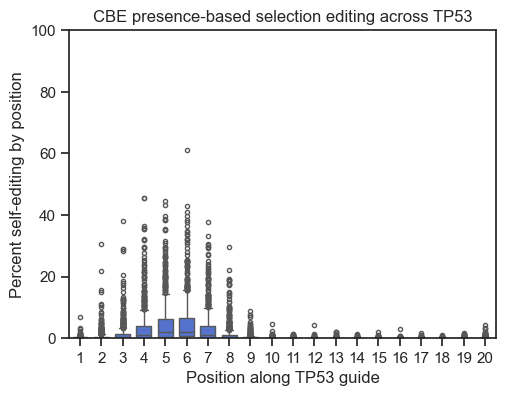

In [48]:
fig, ax = plt.subplots(figsize=(5.5, 4))
a = sns.boxplot(data=sgrna_edit_cbe_pos_presence, y="editing_per_nt", x="loc_mismatch", color='royalblue',width=.7,fliersize=3)
a.set_xlabel("Position along TP53 guide")
plt.xticks(ticks=range(20), labels=range(1, 21))
a.set_ylim([0,100])
plt.yticks([0, 20, 40, 60, 80, 100])
a.set_ylabel("Percent self-editing by position")
a.set_title("CBE presence-based selection editing across TP53")

In [49]:
counts_merged_final = mapping_adding(unexpected_count, align_to_df, counts)
counts_merged_final.to_csv('../../required_data/TP53/counts_with_mismatches_CBE_presence.csv')

/var/folders/nm/6_wl7tx50tq5bqfp8vzf4m6r0000gq/T/ipykernel_68353/1401985157.py:8: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  unexpected_count_grouped = unexpected_count.groupby(unexpected_count.columns, axis=1).sum()


# CBE activity-based selection

In [5]:
condition = pd.read_csv('../../required_data/TP53/GPP-5316_Ganna Reint_conditions.csv', header = None)
reference = pd.read_csv('../../required_data/TP53/TP53_tiling_NNNN_BE_annotations.csv')
unexpected_count = pd.read_table('../../required_data/TP53/unexpected_counts_TP53_activity.txt')
counts = pd.read_table('../../required_data/TP53/counts_TP53_activity.txt')

In [51]:
def regex_seq(reference_df, guide_seq_col = 'sgRNA Target Sequence', 
              chr_change = 'C', regex_pattern = '[CT]'):
    #adds a column to the reference file with regex representing all possible combinations of A>G (or C>T if CBE) edits that may occur within a guide
    regex_list = []
    for seq in reference_df[guide_seq_col]:
        pos_a = [pos for pos, char in enumerate(seq) if char == chr_change]
        temp = list(seq)
        for pos in pos_a:
            temp[pos] = regex_pattern
        string = "".join(temp)
        regex_list.append(string)
    reference_df['regex'] = regex_list

In [52]:
newcol_name(unexpected_count, condition)
regex_seq(reference)
seq_match, dic_seq_match = regex_match(reference, unexpected_count)
align_to_df, AG_pos_mismatch= df_align(dic_seq_match)

In [53]:
#limit scope to only TP53-targeting genes from the DO condition
cols = ['Construct Barcode','Construct IDs','A549_RDB270CP2089DropoutA21', 'A549_RDB270CP2090DropoutA21']
counts_DO = counts[cols]
counts_DO = counts_DO[counts_DO['Construct IDs']=='ENSG00000141510']

unexpected_count_DO = unexpected_count[['Sequence', 'A549_RDB270CP2089DropoutA21', 'A549_RDB270CP2090DropoutA21']]

In [54]:
#find the total number of mismatches of these conditions
cols_to_sum = ['A549_RDB270CP2089DropoutA21', 'A549_RDB270CP2090DropoutA21']
unexpected_count_DO['Total']=unexpected_count_DO[cols_to_sum].sum(axis=1)

/var/folders/nm/6_wl7tx50tq5bqfp8vzf4m6r0000gq/T/ipykernel_68353/2561970722.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unexpected_count_DO['Total']=unexpected_count_DO[cols_to_sum].sum(axis=1)


In [55]:
sum_by_sg_cbe_activity  = percent_mismatch(cols_to_sum, counts_DO, unexpected_count_DO, align_to_df)

sgrna_edit_cbe_pos_activity = across_guide(align_to_df, unexpected_count_DO, sum_by_sg_cbe_activity)

Text(0.5, 1.0, 'CBE activity-based selection editing across TP53')

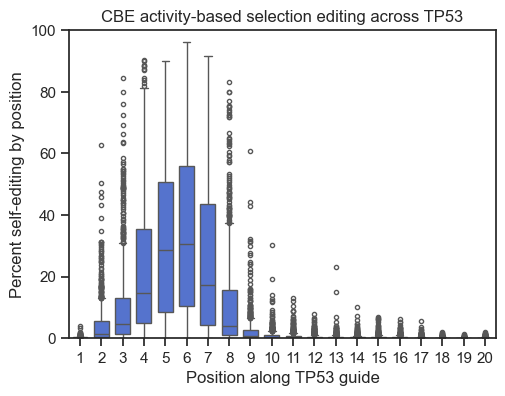

In [58]:
fig, ax = plt.subplots(figsize=(5.5, 4))
a = sns.boxplot(data=sgrna_edit_cbe_pos_activity, y="editing_per_nt", x="loc_mismatch", color='royalblue',width=.7,fliersize=3)
a.set_xlabel("Position along TP53 guide")
plt.xticks(ticks=range(20), labels=range(1, 21))
a.set_ylim([0,100])
plt.yticks([0, 20, 40, 60, 80, 100])
a.set_ylabel("Percent self-editing by position")
a.set_title("CBE activity-based selection editing across TP53")

In [59]:
counts_merged_final = mapping_adding(unexpected_count, align_to_df, counts)
counts_merged_final.to_csv('../../required_data/TP53/counts_with_mismatches_CBE_activity.csv')

/var/folders/nm/6_wl7tx50tq5bqfp8vzf4m6r0000gq/T/ipykernel_68353/1401985157.py:8: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  unexpected_count_grouped = unexpected_count.groupby(unexpected_count.columns, axis=1).sum()


# pDNA self-editing

In [6]:
condition = pd.read_csv('../../required_data/TP53/GPP-5315_Ganna Reint_conditions.csv', header = None)
reference = pd.read_csv('../../required_data/TP53/TP53_tiling_NNNN_BE_annotations.csv')
unexpected_count = pd.read_table('../../required_data/TP53/unexpected_counts_TP53_presence.txt')
counts = pd.read_table('../../required_data/TP53/counts_TP53_presence.txt')

condition_pdna = condition[condition[1]=="CP1845"]

### pDNA C>T

In [61]:
def regex_seq(reference_df, guide_seq_col = 'sgRNA Target Sequence', 
              chr_change = 'C', regex_pattern = '[CT]'):
    #adds a column to the reference file with regex representing all possible combinations of A>G (or C>T if CBE) edits that may occur within a guide
    regex_list = []
    for seq in reference_df[guide_seq_col]:
        pos_a = [pos for pos, char in enumerate(seq) if char == chr_change]
        temp = list(seq)
        for pos in pos_a:
            temp[pos] = regex_pattern
        string = "".join(temp)
        regex_list.append(string)
    reference_df['regex'] = regex_list

In [62]:
newcol_name(unexpected_count, condition_pdna)

unexpected_count_pdna = unexpected_count[["Sequence", "CP1845"]]
unexpected_count_pdna['Total'] = unexpected_count_pdna["CP1845"].sum(axis=1)

regex_seq(reference)
seq_match, dic_seq_match = regex_match(reference, unexpected_count_pdna)
align_to_df, AG_pos_mismatch= df_align(dic_seq_match)

/var/folders/nm/6_wl7tx50tq5bqfp8vzf4m6r0000gq/T/ipykernel_68353/1579295936.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  condition_df[1] = condition_df[1].replace(np.nan, 'Nothing') #laura changed np.NaN to np.nan
/var/folders/nm/6_wl7tx50tq5bqfp8vzf4m6r0000gq/T/ipykernel_68353/1458470492.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unexpected_count_pdna['Total'] = unexpected_count_pdna["CP1845"].sum(axis=1)


In [63]:
#limit scope to only TP53-targeting genes
counts_TP53 = counts[counts['Construct IDs']=='ENSG00000141510']

cols_to_sum = ['CP1845']
unexpected_count_TP53 = unexpected_count.copy()
unexpected_count_TP53['Total']=unexpected_count[cols_to_sum].sum(axis=1)

In [73]:
sum_by_sg_pdna_cbe  = percent_mismatch(cols_to_sum, counts_TP53, unexpected_count_TP53, align_to_df) #laura added  

/var/folders/nm/6_wl7tx50tq5bqfp8vzf4m6r0000gq/T/ipykernel_68353/1814299548.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  counts['sg_count_total'] = counts[cols_to_sum].sum(axis=1)


### pDNA A>G

In [74]:
def regex_seq(reference_df, guide_seq_col = 'sgRNA Target Sequence', 
              chr_change = 'A', regex_pattern = '[AG]'):
    #adds a column to the reference file with regex representing all possible combinations of A>G (or C>T if CBE) edits that may occur within a guide
    regex_list = []
    for seq in reference_df[guide_seq_col]:
        pos_a = [pos for pos, char in enumerate(seq) if char == chr_change]
        temp = list(seq)
        for pos in pos_a:
            temp[pos] = regex_pattern
        string = "".join(temp)
        regex_list.append(string)
    reference_df['regex'] = regex_list

In [75]:
newcol_name(unexpected_count, condition_pdna)

unexpected_count_pdna = unexpected_count[["Sequence", "CP1845"]]
unexpected_count_pdna['Total'] = unexpected_count_pdna["CP1845"].sum(axis=1)

regex_seq(reference)
seq_match, dic_seq_match = regex_match(reference, unexpected_count_pdna)
align_to_df, AG_pos_mismatch= df_align(dic_seq_match)

/var/folders/nm/6_wl7tx50tq5bqfp8vzf4m6r0000gq/T/ipykernel_68353/1579295936.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  condition_df[1] = condition_df[1].replace(np.nan, 'Nothing') #laura changed np.NaN to np.nan
/var/folders/nm/6_wl7tx50tq5bqfp8vzf4m6r0000gq/T/ipykernel_68353/1458470492.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unexpected_count_pdna['Total'] = unexpected_count_pdna["CP1845"].sum(axis=1)


In [76]:
#limit scope to only TP53-targeting genes
counts_TP53 = counts[counts['Construct IDs']=='ENSG00000141510']

cols_to_sum = ['CP1845']
unexpected_count_TP53 = unexpected_count.copy()
unexpected_count_TP53['Total']=unexpected_count[cols_to_sum].sum(axis=1)

In [77]:
sum_by_sg_pdna_abe  = percent_mismatch(cols_to_sum, counts_TP53, unexpected_count_TP53, align_to_df) #laura added  

/var/folders/nm/6_wl7tx50tq5bqfp8vzf4m6r0000gq/T/ipykernel_68353/1814299548.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  counts['sg_count_total'] = counts[cols_to_sum].sum(axis=1)


# Self-editing rate plot

In [78]:
sum_by_sg_abe_activity['rank'] = sum_by_sg_abe_activity['percent'].rank(ascending=False)
sum_by_sg_abe_activity['ID'] = 'ABE activity'
sum_by_sg_abe_presence['rank'] = sum_by_sg_abe_presence['percent'].rank(ascending=False)
sum_by_sg_abe_presence['ID'] = 'ABE presence'
sum_by_sg_cbe_activity['rank'] = sum_by_sg_cbe_activity['percent'].rank(ascending=False)
sum_by_sg_cbe_activity['ID'] = 'CBE activity'
sum_by_sg_cbe_presence['rank'] = sum_by_sg_cbe_presence['percent'].rank(ascending=False)
sum_by_sg_cbe_presence['ID'] = 'CBE presence'
sum_by_sg_pdna_cbe['rank'] = sum_by_sg_pdna_cbe['percent'].rank(ascending=False)
sum_by_sg_pdna_cbe['ID'] = 'pDNA CBE'
sum_by_sg_pdna_abe['rank'] = sum_by_sg_pdna_abe['percent'].rank(ascending=False)
sum_by_sg_pdna_abe['ID'] = 'pDNA ABE'

In [79]:
concat = pd.concat([sum_by_sg_abe_presence, sum_by_sg_abe_activity, 
                    sum_by_sg_cbe_presence, sum_by_sg_cbe_activity,
                   sum_by_sg_pdna_cbe, sum_by_sg_pdna_abe], axis=0, ignore_index=True)

,Construct Barcode,mismatch_total,sg_count_total,percent,rank,ID
0,AAAAAACTCATGTTCAAGAC,105.0,7527.0,1.394978,1558.0,ABE presence
1,AAAAACTCATGTTCAAGACA,293.0,13076.0,2.240746,1044.0,ABE presence
2,AAAAAGGGTCAGTCTACCTC,295.0,11800.0,2.500000,940.0,ABE presence
3,AAAACAACGTTCTGGTAAGG,814.0,17663.0,4.608504,457.0,ABE presence
4,AAAACATCTTGTTGAGGGCA,221.0,17725.0,1.246827,1681.0,ABE presence
...,...,...,...,...,...,...
16705,TTTGCGTGTGGAGTATTTGG,19.0,8305.0,0.228778,2614.0,pDNA ABE
16706,TTTGGACTTCAGGTGGCTGT,22.0,6209.0,0.354324,2484.0,pDNA ABE
16707,TTTGGATGACAGAAACACTT,91.0,5201.0,1.749664,777.0,pDNA ABE
16708,TTTGGCTGGGGAGAGGAGCT,38.0,6078.0,0.625206,2124.0,pDNA ABE


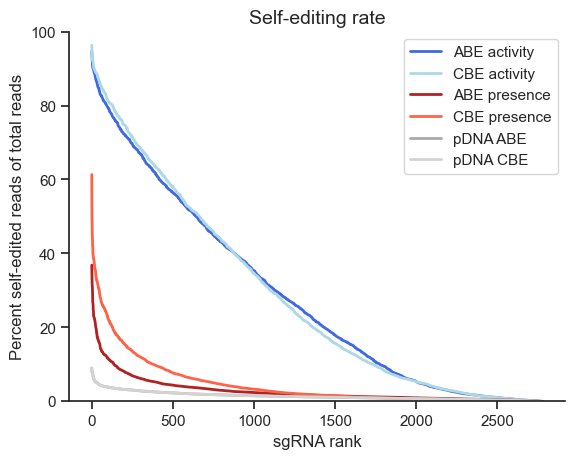

In [80]:
fig, ax = plt.subplots()
colors = {"ABE activity": 'royalblue', 
          "CBE activity": 'lightblue',
         'ABE presence': 'firebrick',
         'CBE presence': 'tomato',
         'pDNA ABE': 'darkgrey',
         'pDNA CBE': 'lightgrey'}
sns.lineplot(data=concat, x='rank', y="percent", hue='ID',palette=colors, hue_order=['ABE activity', 'CBE activity',
                                                                                    'ABE presence', 'CBE presence',
                                                                                    'pDNA ABE', 'pDNA CBE'], 
            linewidth=2)
ax.set_ylim(0,100)
ax.set(xlabel='sgRNA rank', ylabel='Percent self-edited reads of total reads')
ax.set_title("Self-editing rate", fontsize=14)
plt.legend(title='')
sns.despine()
plt.show()